Series([], dtype: int64)


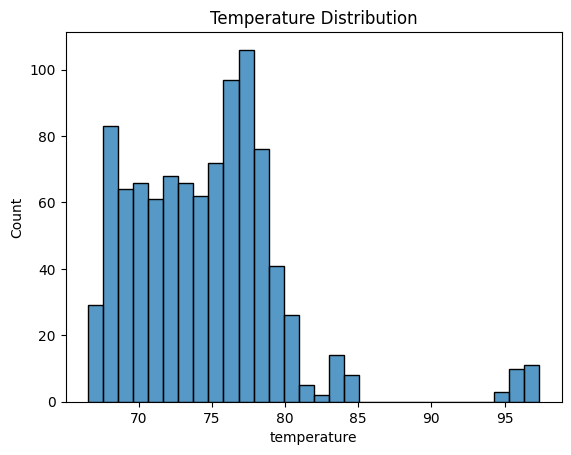

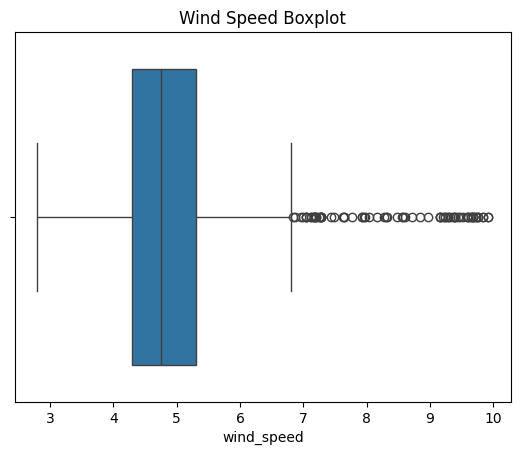

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
file_path = './data/FUSER/train/2022-09-01.csv'
fuser_df = pd.read_csv(file_path)
nan_s = fuser_df.isnull().sum()

# Step 1: Forward and backward fill for continuity in the time series
#merged_df[numeric_cols] = merged_df[numeric_cols].ffill().bfill()

# Step 2: Interpolate to fill in gaps with linear transitions between data points
#merged_df[numeric_cols] = merged_df[numeric_cols].interpolate(method='linear', limit_direction='both')

# Step 3: Fill any remaining NaNs using a rolling mean over a 3-hour (12 intervals of 15 minutes) window
#merged_df[numeric_cols] = merged_df[numeric_cols].fillna(
#    merged_df[numeric_cols].rolling(window=12, min_periods=1).mean()
#)

# Step 4: Optional - Drop any remaining rows with NaNs if necessary
#merged_df.dropna(inplace=True)
print(nan_s[nan_s> 0])



sns.histplot(fuser_df['temperature'], bins=30)
plt.title('Temperature Distribution')
plt.show()

# 风速箱线图
sns.boxplot(x=fuser_df['wind_speed'])
plt.title('Wind Speed Boxplot')
plt.show()